In [1]:
import numpy as np
import pandas as pd
import glob
import os
import re

from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.float_format = "{:,.3f}".format

# Results

In [39]:
def read_in_distribution_rs(res_dir):
    net_dir = [_dir.split('/')[-2] for _dir in sorted(glob.glob(f"{res_dir}/*/"))]
    results_last = {'top1': dict(), 'top5': dict()}
    results_best = {'top1': dict(), 'top5': dict()}
    results_fair = {'top1': dict(), 'top5': dict()}
    for net_name in net_dir:
        if os.path.exists(f"{res_dir}/{net_name}/test_in_distribution_best_test.csv") is False:
            continue
        if os.path.exists(f"{res_dir}/{net_name}/test_in_distribution_last_epoch.csv") is False:
            continue
        res_best = pd.read_csv(f"{res_dir}/{net_name}/test_in_distribution_best_test.csv")
        res_last = pd.read_csv(f"{res_dir}/{net_name}/test_in_distribution_last_epoch.csv")
        # results_best['top1'][net_name] = np.max(net_res['top1'])
        # results_best['top5'][net_name] = np.max(net_res['top5'])
        # results_last['top1'][net_name] = np.array(net_res['top1'])[-1]
        # results_last['top5'][net_name] = np.array(net_res['top5'])[-1]
        results_fair['top1'][net_name] = (np.mean(res_best['top1']) + np.mean(res_last['top1'])) / 2
        results_fair['top5'][net_name] = (np.mean(res_best['top5']) + np.mean(res_last['top5'])) / 2
    return results_last, results_best, results_fair


def read_all_subjects_res(res_dir):
    net_dir = [_dir.split('/')[-2] for _dir in sorted(glob.glob(f"{res_dir}/*/"))]
    results_last = {'top1': dict(), 'top5': dict()}
    results_best = {'top1': dict(), 'top5': dict()}
    results_fair = {'top1': dict(), 'top5': dict()}
    for net_name in net_dir:
        if os.path.exists(f"{res_dir}/{net_name}/losses.csv") is False:
            continue
        net_res = pd.read_csv(f"{res_dir}/{net_name}/losses.csv")
        results_best['top1'][net_name] = np.max(net_res['top1'])
        results_best['top5'][net_name] = np.max(net_res['top5'])
        results_last['top1'][net_name] = np.array(net_res['top1'])[-1]
        results_last['top5'][net_name] = np.array(net_res['top5'])[-1]
        results_fair['top1'][net_name] = (results_best['top1'][net_name] + results_last['top1'][net_name]) / 2
        results_fair['top5'][net_name] = (results_best['top5'][net_name] + results_last['top5'][net_name]) / 2
    return results_last, results_best, results_fair


def result_dataframe(experiment_dir, topk, epoch, wfun, baseline=False):
    experiments = sorted(glob.glob(f"{experiment_dir}/*/"))

    summary_df = pd.DataFrame(columns=[
        "pre-arch", "pre-db", "pre-layer", "pre-fsize", "eeg-arch", "eeg-sampling", "instance",
        *[f"s{i:02d}" for i in range(1, 11)], 'avg'
    ])
    experiments = [_e for _e in experiments if 'INDIST' not in _e]

    for res_ind, res_dir in enumerate(experiments):
        results_last, results_best, results_fair = wfun(res_dir)
        if epoch == 'fair':
            rep_res = results_fair
        else:
            rep_res = results_last if epoch == 'last' else results_best
        res_split = res_dir.split('/')[-2].split('__')
    
        # Use re.match to check if the string matches the pattern
        if re.match(r"^i0[0-9]|i10$", res_split[-1]):
            summary_df.loc[res_ind, 'instance'] = int(res_split[-1][1:])
            res_split = res_split[:-1]
        else:
            summary_df.loc[res_ind, 'instance'] = 0
        
        summary_df.loc[res_ind, 'pre-arch'] = res_split[0]
        summary_df.loc[res_ind, 'pre-db'] = res_split[1]
        summary_df.loc[res_ind, 'pre-layer'] = res_split[2]
        summary_df.loc[res_ind, 'pre-fsize'] = res_split[3]
        summary_df.loc[res_ind, 'eeg-arch'] = res_split[4]
        summary_df.loc[res_ind, 'eeg-sampling'] = "image" if res_split[-1] == "baseline" else "concept"
        if res_split[-1] == 'resampling':
              summary_df.loc[res_ind, 'eeg-sampling'] += "_s"

        accs = []
        for _k, _v in rep_res[f"top{topk}"].items():
            summary_df.loc[res_ind, f"s{_k[4:6]}"] = _v
            accs.append(_v)
        summary_df.loc[res_ind, 'avg'] = np.mean(accs)
    return summary_df


def result_dataframe_combinations(experiment_dir, wf=read_all_subjects_res, baseline=False):
    df = dict()
    for top in [1, 5]:
        for epoch in ['last', 'best', 'fair']:
            df[f'{epoch}_{top}'] = result_dataframe(experiment_dir, top, epoch, wf, baseline=baseline)
    return df

In [4]:
def filter_df(df, column, filter_vals, exclude=False):
    if type(filter_vals) == str:
        filter_vals = [filter_vals]
    condition = df[column].isin(filter_vals)
    if exclude:
        condition = ~condition
    new_df = df[condition]
    new_df = new_df.reset_index(drop=True)
    return new_df

## Intraparticipant

In [35]:
experiment_dir = "./results/intra_subjects/"
df_intraparticipant = result_dataframe_combinations(experiment_dir)

In [36]:
df_intraparticipant['fair_1'].sort_values('avg', ascending=False)

,pre-arch,pre-db,pre-layer,pre-fsize,eeg-arch,eeg-sampling,instance,s01,s02,s03,s04,s05,s06,s07,s08,s09,s10,avg
15,ViT-B-16,laion400m_e31,visual-language,1024,atm,concept_s,0,0.260,0.195,0.220,0.305,0.172,0.253,0.220,0.295,0.240,0.263,0.242
21,ViT-B-32,laion400m_e31,visual-language,1024,atm,concept_s,0,0.215,0.193,0.240,0.315,0.143,0.247,0.240,0.275,0.240,0.235,0.234
18,ViT-B-16,laion400m_e31,visual,512,atm,concept_s,0,0.235,0.190,0.217,0.277,0.180,0.200,0.225,0.297,0.225,0.245,0.229
30,ViT-H-14,laion2b_s32b_b79k,visual-language,2048,atm,concept_s,1,0.200,0.195,0.225,0.292,0.172,0.230,0.210,0.292,0.215,0.240,0.227
16,ViT-B-16,laion400m_e31,visual-language,1024,nice,concept_s,0,0.220,0.180,0.225,0.255,0.158,0.240,0.205,0.318,0.217,0.255,0.227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,ViT-L-14,clip,visual,768,nice,image,0,0.120,0.105,0.133,0.165,0.098,0.135,0.135,0.205,0.170,0.152,0.142
40,ViT-L-14,clip,visual,768,atm,image,0,0.140,0.110,0.140,0.198,0.095,0.120,0.138,0.170,0.128,0.167,0.140
5,RN50,clip,block3,1024,atm,concept_s,0,0.117,0.090,0.115,0.125,0.105,0.098,0.113,0.128,0.117,0.110,0.112
4,RN50,clip,block2,512,atm,concept_s,0,0.077,0.065,0.075,0.077,0.068,0.070,0.073,0.082,0.060,0.068,0.071


In [6]:
df_intraparticipant['fair_1'].to_csv('intra_top1.csv')
df_intraparticipant['fair_5'].to_csv('ntra_top5.csv')

In [153]:
pd.concat([df_intraparticipant['fair_1'], df_intraparticipant['fair_5'].iloc[:, 7:]], axis=1, join='outer').to_csv('intra_tops.csv')

## Interparticipant

In [7]:
experiment_dir = "./results/inter_subjects/"
df_interparticipant = result_dataframe_combinations(experiment_dir)

In [8]:
df_interparticipant['fair_1'].sort_values('avg', ascending=False)

,pre-arch,pre-db,pre-layer,pre-fsize,eeg-arch,eeg-sampling,instance,s01,s02,s03,s04,s05,s06,s07,s08,s09,s10,avg
18,ViT-H-14,laion2b_s32b_b79k,visual-language,2048,atm,concept,0,0.090,0.110,0.058,0.100,0.090,0.082,0.095,0.087,0.075,0.140,0.093
14,ViT-B-32,laion400m_e31,visual,512,atm,concept,0,0.113,0.100,0.070,0.092,0.073,0.077,0.075,0.080,0.070,0.150,0.090
0,ViT-B-16,laion2b_s34b_b88k,visual,512,atm,concept,0,0.095,0.090,0.062,0.110,0.073,0.075,0.068,0.090,0.055,0.165,0.088
4,ViT-B-16,laion400m_e31,visual,512,atm,concept,0,0.103,0.090,0.075,0.075,0.090,0.075,0.082,0.073,0.057,0.160,0.088
2,ViT-B-16,laion400m_e31,visual-language,1024,atm,concept,0,0.100,0.092,0.070,0.103,0.062,0.073,0.073,0.070,0.085,0.143,0.087
10,ViT-B-32,laion400m_e31,visual-language,1024,atm,concept,0,0.092,0.115,0.060,0.098,0.058,0.087,0.060,0.070,0.075,0.138,0.085
22,ViT-H-14,laion2b_s32b_b79k,visual,1024,nice,concept,0,0.100,0.100,0.070,0.070,0.062,0.087,0.065,0.075,0.060,0.147,0.084
21,ViT-H-14,laion2b_s32b_b79k,visual,1024,atm,concept,0,0.083,0.105,0.065,0.087,0.087,0.060,0.075,0.072,0.068,0.135,0.084
3,ViT-B-16,laion400m_e31,visual-language,1024,nice,concept,0,0.098,0.098,0.075,0.083,0.045,0.085,0.053,0.065,0.087,0.145,0.083
6,ViT-B-16,laion400m_e31,visual,512,nice,concept,0,0.098,0.098,0.070,0.085,0.052,0.065,0.055,0.068,0.078,0.145,0.081


In [9]:
df_interparticipant['fair_1'].to_csv('inter_top1.csv')
df_interparticipant['fair_5'].to_csv('inter_top5.csv')

In [12]:
pd.concat([df_interparticipant['fair_1'], df_interparticipant['fair_5'].iloc[:, 7:]], axis=1, join='outer').to_csv('inter_tops.csv')

# Effects

In [10]:
def find_paired_rows(df, columns):
    paired_rows = []
    for row_i_ind, row_i_val in df.iterrows():
        for row_j_ind, row_j_val in df.iterrows():
            if row_i_ind < row_j_ind:
                if np.all(row_i_val[columns] == row_j_val[columns]):
                    paired_rows.append([row_i_ind, row_j_ind])
    return paired_rows


def get_significance(p):
    significance = ""
    for p_ths in [0.05, 0.01, 0.001]:
        if p <= p_ths:
            significance += '*'
    return significance


def report_effect(gain, effect_name):
    gain = gain.astype('float').flatten()
    s, p = stats.wilcoxon(list(gain), alternative='greater', method='auto')
    significance = get_significance(p)
    print(f"{effect_name} gain: {np.mean(gain):.3f} – {p:.0e} {significance} [N={len(gain)}]")
    return p


def report_gain(x, y, effect_name):
    columns = 'avg'
    gain_avg = x.loc[:, columns].to_numpy() - y.loc[:, columns].to_numpy()
    p_avg = report_effect(gain_avg, "[Average] " + effect_name)

    subject_order = np.arange(1, 11)
    np.random.shuffle(subject_order)
    columns = [f"s{i:02d}" for i in subject_order]
    x_cols = x.loc[:, columns].to_numpy()
    np.random.shuffle(subject_order)
    columns = [f"s{i:02d}" for i in subject_order]
    y_cols = y.loc[:, columns].to_numpy()
    gain_sub = x_cols - y_cols
    p_sub = report_effect(gain_sub, "[Subject] " + effect_name)
    return p_avg, p_sub, np.mean(gain_avg)


def sort_paired_rows(df, paired_rows, column, value):
    selected_pairs = []
    for p_ind, p_row in enumerate(paired_rows):
        isval0 = df.loc[p_row[0], column] == value
        isval1 = df.loc[p_row[1], column] == value
        if isval0 and isval1:
            continue
        if isval0:
            selected_pairs.append(p_row)
        elif isval1:
            selected_pairs.append(p_row[::-1])
    paired_rows = np.array(selected_pairs)
    return paired_rows


def compute_language_effect(df, filter_arch=None):
    df_filtered = df.copy()
    # df_filtered.loc[df_filtered['eeg-sampling'] == 'concept_s', 'eeg-sampling'] = 'concept'
    df_filtered = filter_df(df_filtered, 'pre-layer', ['visual', 'visual-language'])
    
    identical_columns = ['pre-arch', 'pre-db', 'eeg-sampling', 'instance']

    if filter_arch is not None:        
        df_filtered =  filter_df(df_filtered, 'eeg-arch', filter_arch)
    else:
        identical_columns.append('eeg-arch')
    
    paired_rows = find_paired_rows(df_filtered, identical_columns)
    paired_rows = sort_paired_rows(df_filtered, paired_rows, 'pre-layer', 'visual-language')

    df_visuallanguage = df_filtered.iloc[paired_rows[:, 0]]
    df_visual = df_filtered.iloc[paired_rows[:, 1]]

    p_avg, p_sub, gain_val = report_gain(df_visuallanguage, df_visual, 'Multimodal visual-language')
    return df_visuallanguage, df_visual, p_avg, p_sub, gain_val


def compute_resampling_effect(df, filter_arch=None):
    identical_columns = ['pre-arch', 'pre-db', 'pre-layer', 'instance']

    df_filtered = df.copy()
    if filter_arch is not None:        
        df_filtered =  filter_df(df_filtered, 'eeg-arch', filter_arch)
    else:
        identical_columns.append('eeg-arch')
    
    paired_rows = find_paired_rows(df_filtered, identical_columns)
    paired_rows = sort_paired_rows(df_filtered, paired_rows, 'eeg-sampling', 'image')
    
    df_baseline = df_filtered.iloc[paired_rows[:, 0]]
    df_resampling = df_filtered.iloc[paired_rows[:, 1]]

    p_avg, p_sub, gain_val = report_gain(df_resampling, df_baseline, 'Resampling expansion space')
    return df_resampling, df_baseline, p_avg, p_sub, gain_val


def compute_arch_effect(df):
    df_filtered = df.copy()
    identical_columns = ['pre-arch', 'pre-db', 'pre-layer', 'eeg-sampling', 'instance']
    
    paired_rows = find_paired_rows(df_filtered, identical_columns)
    paired_rows = np.array(paired_rows)
    
    df_atm = df_filtered.iloc[paired_rows[:, 0]]
    df_nice = df_filtered.iloc[paired_rows[:, 1]]

    report_gain(df_nice, df_atm, 'Nice architecture')
    report_gain(df_atm, df_nice, 'ATM architecture')


def compute_prearch_effect(df):
    df_filtered = df.copy()
    condition = df_filtered['pre-db'].isin(['laion400m_e31', 'laion400m_e32'])
    df_filtered.loc[condition, 'pre-db'] = 'laison400m'
    laion2b = [db for db in np.unique(df_filtered['pre-db']) if 'laion2b_' in db]
    condition = df_filtered['pre-db'].isin(laion2b)
    df_filtered.loc[condition, 'pre-db'] = 'laion2b'

    identical_columns = ['pre-arch', 'pre-layer', 'eeg-arch', 'eeg-sampling', 'instance']    
    paired_rows = find_paired_rows(df_filtered, identical_columns)
    paired_rows = np.array(paired_rows)
    
    df_atm = df_filtered.iloc[paired_rows[:, 0]]
    df_nice = df_filtered.iloc[paired_rows[:, 1]]

    report_gain(df_nice, df_atm, 'Nice architecture')
    report_gain(df_atm, df_nice, 'ATM architecture')

In [11]:
from matplotlib.ticker import FormatStrFormatter

def plot_gain_fig(baseline, gain, p_avg, p_sub, gain_val, xlabel, ylabel, title):
    fontsize = 16
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)

    sub_baseline = baseline.iloc[:, -11:-1].to_numpy().flatten()
    sub_gain = gain.iloc[:, -11:-1].to_numpy().flatten()
    min_val = np.min([*sub_baseline, *sub_gain])
    max_val = np.max([*sub_baseline, *sub_gain])
    ax.plot(sub_baseline, sub_gain, '.', color='gray', alpha=0.6, label=r'$Ind.\bf{^{%s}}$' % (get_significance(p_sub)) + ' $p$=%.0e [N=%d]' % (p_sub, len(baseline) * 10))
    
    ax.plot(baseline['avg'], gain['avg'], 'x', color='black', markersize=7, markeredgewidth=3, label=r'$Avg.\bf{^{%s}}$' % (get_significance(p_avg)) + ' $p$=%.0e [N=%d]' % (p_avg, len(baseline)))
    ax.set_ylim([min_val * 0.95, max_val * 1.05])
    ax.set_xlim([min_val * 0.95, max_val * 1.05])
    ax.axline((min_val, min_val), slope=1, ls="--", color='g')
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    # ax.set_yticks([0.06, 0.07, 0.08, 0.09])
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_title(title, fontsize=fontsize)
    ax.legend(loc='lower right')
    return fig

## Sampling

In [12]:
df_resampling, df_baseline, resampling_p_avg, resampling_p_sub, resampling_gain = compute_resampling_effect(
    df_interparticipant['fair_1'])

[Average] Resampling expansion space gain: 0.015 – 1e-04 *** [N=13]
[Subject] Resampling expansion space gain: 0.015 – 1e-05 *** [N=130]


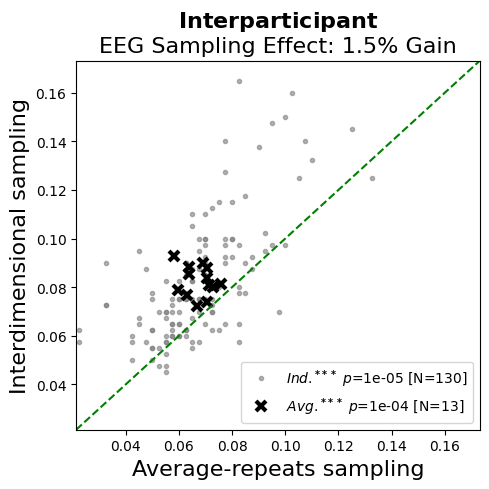

In [13]:
fig = plot_gain_fig(df_baseline, df_resampling, resampling_p_avg, resampling_p_sub, resampling_gain,
                    'Average-repeats sampling', 'Interdimensional sampling',
                    r'$\bf{Interparticipant}$'+'\nEEG Sampling Effect: %.1f%% Gain' % (resampling_gain*100))
fig.tight_layout()
fig.savefig('inter_sampling.svg')

In [14]:
intra_df_resampling, intra_df_baseline, intra_resampling_p_avg, intra_resampling_p_sub, intra_resampling_gain = compute_resampling_effect(
    df_intraparticipant['fair_1'])

[Average] Resampling expansion space gain: 0.030 – 3e-05 *** [N=15]
[Subject] Resampling expansion space gain: 0.030 – 3e-15 *** [N=150]


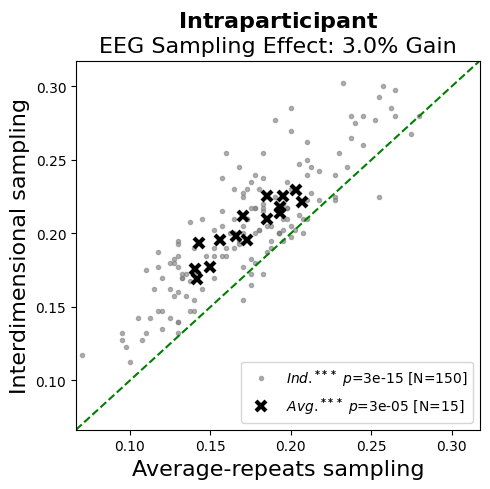

In [15]:
fig = plot_gain_fig(intra_df_baseline, intra_df_resampling, intra_resampling_p_avg, intra_resampling_p_sub, intra_resampling_gain,
                    'Average-repeats sampling', 'Interdimensional sampling',
                    r'$\bf{Intraparticipant}$'+'\nEEG Sampling Effect: %.1f%% Gain' % (intra_resampling_gain*100))
fig.tight_layout()
fig.savefig('intra_sampling.svg')

## Multimodal

In [190]:
df = df_interparticipant['fair_1'].copy()
df = filter_df(df, 'eeg-sampling', 'image', True)
inter_df_multimodal, inter_df_visual, inter_language_p_avg, inter_language_p_sub, inter_language_gain = compute_language_effect(df)

[Average] Multimodal visual-language gain: 0.001 – 3e-01  [N=6]
[Subject] Multimodal visual-language gain: 0.001 – 4e-01  [N=60]


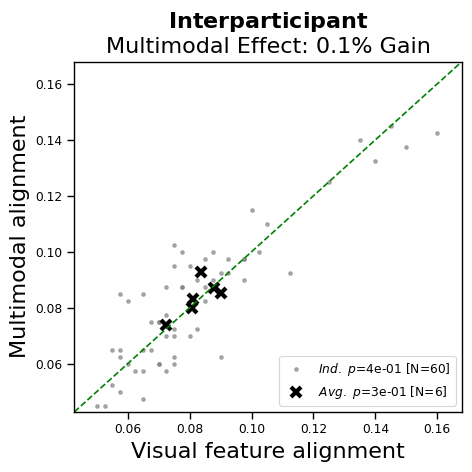

In [191]:
fig = plot_gain_fig(inter_df_visual, inter_df_multimodal, inter_language_p_avg, inter_language_p_sub, intra_language_gain,
                    'Visual feature alignment', 'Multimodal alignment',
                     r'$\bf{Interparticipant}$'+'\nMultimodal Effect: %.1f%% Gain' % (inter_language_gain*100))
fig.tight_layout()
fig.savefig('inter_multimodal.svg')

In [18]:
df = filter_df(df_intraparticipant['fair_1'], 'eeg-arch', 'atm')
intra_df_multimodal, intra_df_visual, intra_language_p_avg, intra_language_p_sub, intra_language_gain = compute_language_effect(df)

[Average] Multimodal visual-language gain: 0.012 – 8e-03 ** [N=7]
[Subject] Multimodal visual-language gain: 0.012 – 4e-02 * [N=70]


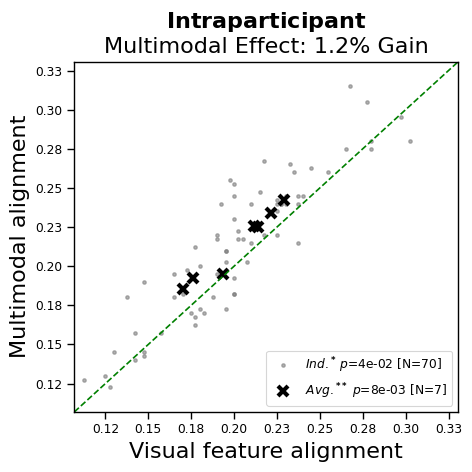

In [192]:
fig = plot_gain_fig(intra_df_visual, intra_df_multimodal, intra_language_p_avg, intra_language_p_sub, intra_language_gain,
                    'Visual feature alignment', 'Multimodal alignment',
                     r'$\bf{Intraparticipant}$'+'\nMultimodal Effect: %.1f%% Gain' % (intra_language_gain*100))
fig.tight_layout()
fig.savefig('intra_multimodal.svg')

## Pretrained

In [19]:
def plot_pretrained_effect(df, title):
    df = filter_df(filter_df(df, 'pre-arch', 'ViT-B-16'), 'pre-layer', 'visual')
    df.loc[df['pre-db'] == 'laion2b_s34b_b88k', 'pre-db'] = 'Laion 2B'
    df.loc[df['pre-db'] == 'openai', 'pre-db'] = 'OpenAI'
    df.loc[df['pre-db'] == 'laion400m_e31', 'pre-db'] = 'Laion 400M'
    df.loc[df['pre-db'] == 'laion400m_e32', 'pre-db'] = 'Laion 400M'
    df.loc[df['eeg-sampling'] != 'image', 'eeg-sampling'] = 'Interdimensional'
    df.loc[df['eeg-sampling'] == 'image', 'eeg-sampling'] = 'Average-Repeats'
    df = df.loc[[2, 3, 0, 1, 4, 5]]
    df = df.reset_index(drop=True)
    if df.loc[0, 'eeg-sampling'] == 'Average-Repeats':
        df = df.loc[[1, 0, 3, 2, 5, 4]]
    df = df.reset_index(drop=True)

    value_vars = ['s%.2d' % i for i in range(1, 11)]
    df_melted = df.reset_index().melt(id_vars=['pre-arch', 'pre-db', 'eeg-sampling'], value_vars=value_vars, value_name='Top-1')
    df_melted = df_melted.rename(columns={'eeg-sampling': 'EEG Sampling'})
    df_melted = df_melted.rename(columns={'pre-db': 'Pretrained Dataset'})

    sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16, 'axes.ticks': 14})   
    fig = plt.figure(figsize=(5, 4))
    sns.violinplot(df_melted, x="EEG Sampling", y="Top-1", hue="Pretrained Dataset")
    plt.title(r'$\bf{%s}$' % title + '\nPretrained Dataset Effect')
    return fig

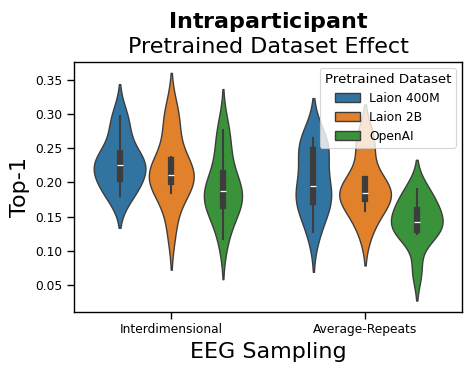

In [20]:
fig = plot_pretrained_effect(df_intraparticipant['fair_1'], 'Intraparticipant')
fig.tight_layout()
fig.savefig('pretrained_intra.svg')

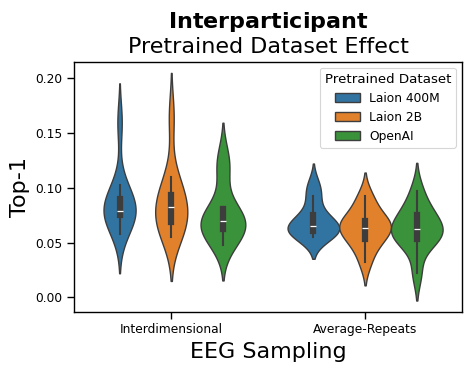

In [21]:
fig = plot_pretrained_effect(
    filter_df(filter_df(df_interparticipant['fair_1'], 'eeg-sampling', 'concept_s', exclude=True), 'eeg-arch', 'nice', True),
    'Interparticipant'
)
fig.tight_layout()
fig.savefig('pretrained_inter.svg')